In [9]:
library(DT)
library(patchwork)
library(igraph)
library(dplyr)
library(ggalluvial)
library(CellChat)
library(Seurat)
library(SeuratDisk)
library(patchwork)
library(pheatmap)

library(Seurat)
library(dplyr)
library(ggplot2)
library(dior)
library(Matrix)
library(rhdf5)
library(reticulate)
suppressWarnings(suppressMessages(future::plan("multiprocess", workers = 8)))

In [10]:
ad <- import("anndata", convert = FALSE)
ad_object <- ad$read_h5ad("../data/v4-qc.h5ad")

data.input <- t(py_to_r(ad_object$X))
rownames(data.input) <- rownames(py_to_r(ad_object$var))
colnames(data.input) <- rownames(py_to_r(ad_object$obs))
# access meta data
meta.data <- py_to_r(ad_object$obs)
meta <- meta.data
cellchat <- createCellChat(object = as.matrix(data.input), meta = meta, group.by = "new_cls")

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 4.1 GiB”


[1] "Create a CellChat object from a data matrix"
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  FLS1 FLS2 Fib1 Fib2 Fib3 Macro1 Macro2 Macro3 T cells 


In [11]:
cellchat <- addMeta(cellchat, meta = meta)

[1] "FLS1"    "FLS2"    "Fib1"    "Fib2"    "Fib3"    "Macro1"  "Macro2" 
[8] "Macro3"  "T cells"

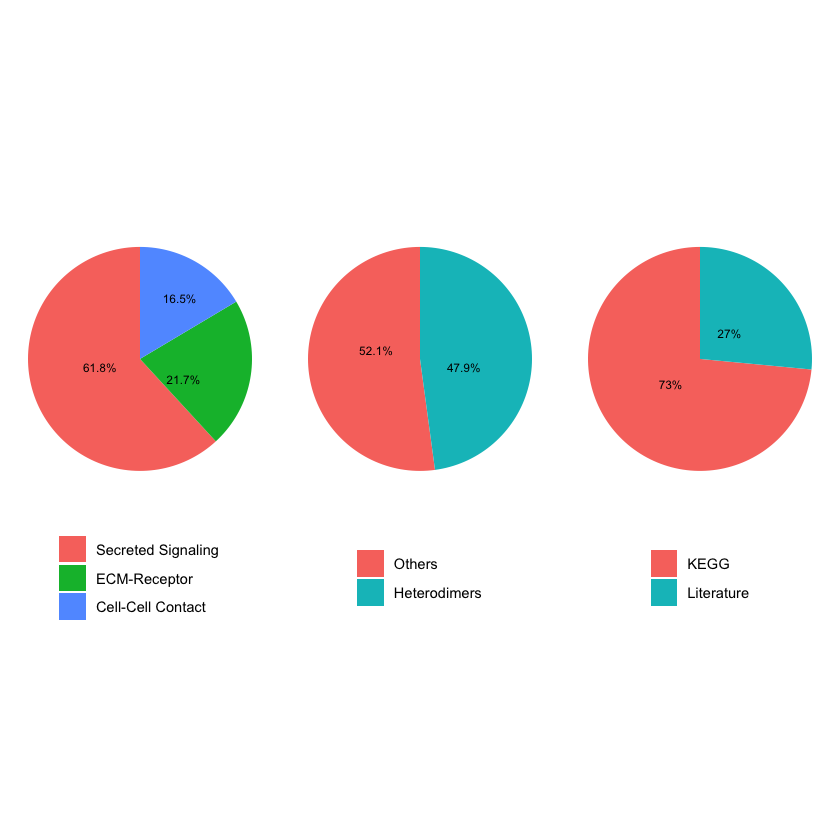

In [13]:
cellchat <- setIdent(cellchat, ident.use = "new_cls") # set "labels" as default cell identity
levels(cellchat@idents) # show factor levels of the cell labels
groupSize <- as.numeric(table(cellchat@idents)) # number of cells in each cell group
CellChatDB <- CellChatDB.human # use CellChatDB.mouse if running on mouse data
showDatabaseCategory(CellChatDB)
ggsave(filename = './figures/cellchat/showadatabase.pdf', width = 10, height = 10)

In [14]:
unique(CellChatDB$interaction$annotation)

[1] "Secreted Signaling" "ECM-Receptor"       "Cell-Cell Contact"

In [15]:
# CellChatDB.use <- subsetDB(CellChatDB, search = "Cell-Cell Contact") 

In [16]:
cellchat@DB <- CellChatDB

In [17]:
cellchat <- subsetData(cellchat)
future::plan("multiprocess", workers = 8) 

In [18]:
cellchat

An object of class CellChat created from a single dataset 
 10000 genes.
 54531 cells. 
CellChat analysis of single cell RNA-seq data! 

In [19]:
cellchat <- identifyOverExpressedGenes(cellchat,)

In [20]:
cellchat <- identifyOverExpressedInteractions(cellchat)

In [21]:
#project gene expression data onto PPI (Optional: when running it, USER 
#should set `raw.use = FALSE` in the function `computeCommunProb()` in order to use the projected data)
# cellchat <- projectData(cellchat, PPI.human)

## 计算通信概率并推断蜂窝通信网络
 如果未预测所研究生物过程中众所周知的信号通路，用户可以尝试truncatedMean更改计算每个细胞群的平均基因表达的方法。

In [22]:
cellchat <- computeCommunProb(cellchat)
# Filter out the cell-cell communication if there are only few number of cells in certain cell groups
cellchat <- filterCommunication(cellchat, min.cells = 10)

triMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2023-03-06 01:06:55]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-03-06 01:10:11]"


## 在信号通路水平上推断细胞间通讯

CellChat 通过汇总与每个信号通路相关的所有配体-受体相互作用的通信概率，计算信号通路水平上的通信概率。

注意：每个配体-受体对和每个信号通路的推断细胞间通信网络分别存储在插槽“net”和“netP”中。


In [23]:
cellchat <- computeCommunProbPathway(cellchat)

## 计算聚合的细胞间通信网络

我们可以通过计算链路数或汇总通信概率来计算聚合的细胞间通信网络。

USER 还可以通过设置sources.use和来计算小区组子集之间的聚合网络targets.use

In [24]:
cellchat <- aggregateNet(cellchat)

In [25]:
groupSize <- as.numeric(table(cellchat@idents))

In [52]:
pdf('./figures/cellchat/Number of interactions.pdf', width = 10, height = 10, )
netVisual_circle(cellchat@net$count, vertex.weight = groupSize,title.name = "Number of interactions",
                vertex.label.cex=1,margin =0.2,alpha.edge=0.5,    edge.width.max = 1
                )
dev.off()

ERROR while rich displaying an object: Error in file(con, "rb"): cannot open the connection

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_png.recordedplot(obj)
8. repr_recordedplot_gener

plot without title

pdf 
  4

In [55]:
pdf('./figures/cellchat/Interaction weights.strength.pdf', width = 10, height = 10)
netVisual_circle(cellchat@net$weight, vertex.weight = groupSize, title.name = "Interaction weights/strength",
                vertex.label.cex=1,margin =0.2,alpha.edge=0.5,    edge.width.max = 2)
dev.off()

ERROR while rich displaying an object: Error in file(con, "rb"): cannot open the connection

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_png.recordedplot(obj)
8. repr_recordedplot_gener

plot without title

pdf 
  4

In [56]:
cellchat@net$weight

,FLS1,FLS2,Fib1,Fib2,Fib3,Macro1,Macro2,Macro3,T cells
FLS1,3.4352394,4.5286524,7.1082081,2.3250391,1.1900206,6.972861,4.662641,9.312871,0.1111111
FLS2,3.3783150,3.7916657,6.8866488,2.3651056,1.3881040,6.068605,4.048653,8.455041,0.0000000
Fib1,2.8744981,3.8560327,6.2247108,1.8677766,0.8023734,5.523341,3.478812,7.609970,0.3153594
Fib2,1.8526030,2.8137195,4.5903634,1.3304555,0.8627065,6.014298,4.028429,7.303817,0.2727273
Fib3,2.9118948,3.6257006,3.7879777,1.8555312,1.5189735,4.653095,4.896557,6.665776,0.3333333
Macro1,1.4391880,1.3885154,1.3853678,0.8813710,0.4518206,8.773932,9.490463,9.260165,0.6751117
Macro2,1.4777230,1.5889531,1.0956868,0.8467700,0.4105107,10.545374,11.255027,11.016772,0.7516340
Macro3,2.7312356,3.5691218,5.4821321,1.6990631,0.6691591,13.711775,12.367478,14.972414,0.7095118
T cells,0.5624882,0.5738545,0.4179665,0.5454545,0.2727273,2.298466,2.528326,2.741935,0.0000000


In [57]:
pheatmap(cellchat@net$weight, cluster_rows = FALSE, cluster_cols = FALSE, filename = './figures/cellchat/123.jpg')

In [22]:
mat <- cellchat@net$weight
par( c(2,2), xpd=TRUE)
for (i in 1:nrow(mat)) {
    mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
    mat2[i, ] <- mat[i, ]
    name = paste('./figures/cellchat/' ,rownames(mat)[i] ,'isolate_plot.pdf')
    pdf(name, width = 10, height = 10)
    netVisual_circle(mat2, vertex.weight = groupSize,  edge.weight.max = max(mat), title.name = rownames(mat)[i])
    dev.off()
}

In [28]:
cellchat@netP$pathways

[1] "MHC-II"     "SEMA3"      "LAMININ"    "PTPRM"      "ANGPTL"    
 [6] "ADGRE5"     "THBS"       "COLLAGEN"   "CXCL"       "EGF"       
[11] "GALECTIN"   "GAS"        "CD45"       "IL16"       "THY1"      
[16] "PDGF"       "CSF"        "EPHA"       "PECAM1"     "MK"        
[21] "COMPLEMENT" "ICAM"       "CADM"       "CHEMERIN"   "ITGB2"     
[26] "TENASCIN"   "FN1"        "NEGR"       "CCL"        "PARs"      
[31] "ncWNT"      "HGF"        "NOTCH"      "IGF"        "IL2"

In [58]:
# pathways.show <- cellchat@netP$pathways
pathways.show <- c('COLLAGEN', 'PDGF', 'IGF', 'ncWNT', 'EGF','HGF', 'NOTCH','IL2','IL16')
# Hierarchy plot
# Here we define `vertex.receive` so that the left portion of the hierarchy plot shows signaling to fibroblast and the right portion shows signaling to immune cells 
for (val in pathways.show){
    vertex.receiver = seq(1,4) # a numeric vector. 
    # Circle plot
    par(mfrow=c(1,1))
    pdf(paste('./figures/cellchat/', val,'_circle.pdf', sep = ''))
    netVisual_aggregate(cellchat, signaling = val, layout = "circle")
    dev.off()
    }

In [32]:
for( val in pathways.show){
    pdf(paste('./figures/cellchat/', val,'_chord.pdf', sep = ''), width = 10, height = 10)
    netVisual_aggregate(cellchat, signaling =val, layout = "chord", vertex.label.cex = 01)
    dev.off()
    }

In [80]:
# val = 'ncWNT'
# pdf(paste('./figures/cellchat/', val,'_heatmap.pdf', sep = ''), width = 10, height = 10)
# #     netVisual_heatmap(cellchat, signaling = val, color.heatmap = "Reds")
# netVisual_heatmap(cellchat, signaling = val, color.heatmap = "Reds")
# dev.off()

In [79]:
pathways.show <- c('COLLAGEN', 'PDGF', 'IGF', 'ncWNT', 'EGF','HGF', 'NOTCH','IL2','IL16')
for( val in pathways.show){
    pdf(paste('./figures/cellchat/', val,'_heatmap.pdf', sep = ''), width = 10, height = 10)
#     netVisual_heatmap(cellchat, signaling = val, color.heatmap = "Reds")
    print(netVisual_heatmap(cellchat, signaling = val, color.heatmap = "Reds"))
    dev.off()
    }


Do heatmap based on a single object 


Do heatmap based on a single object 


Do heatmap based on a single object 


Do heatmap based on a single object 


Do heatmap based on a single object 


Do heatmap based on a single object 


Do heatmap based on a single object 




In [469]:
pdf('./figures/cellchat/contribution.pdf')
netAnalysis_contribution(cellchat, signaling = pathways.show)
dev.off()

pdf 
  2

我们还可以可视化由单个配体-受体对介导的细胞间通讯。我们提供了一个函数extractEnrichedLR来提取给定信号通路的所有重要相互作用（LR 对）和相关信号基因。



In [39]:
pairLR.CXCL <- extractEnrichedLR(cellchat, signaling = pathways.show, geneLR.return = FALSE)
for (val in pathways.show){
    pdf(paste('./figures/cellchat/extract_interaction_of_', val,'_circle.pdf', sep = ''), width = 10,
       height=10)
    netVisual_individual(cellchat, signaling = val,  pairLR.use =pairLR.CXCL)
    dev.off()
    
   
}



# bubble

In [59]:
pdf('./figures/cellchat/bubble_plot.pdf',width = 15,height = 10)
netVisual_bubble(cellchat, remove.isolate = FALSE, title='Bubble plot',signaling = pathways.show)
dev.off()

Comparing communications on a single object 




pdf 
  2

# chord

In [63]:
fib_marker = c('LUM','IGFBP6', 'COL1A1','ASPN', 'FBLN1', 'THY1') # Fibroblasts
macr_marker = c('MS4A6A', 'CD163', 'CD14', 'CYBB', 'CTSS') # Macrophages-m2
fib_syn_marker = c('CLIC5', 'HAS1', 'HBEGF') # Fibroblast-like Synoviocytes
end_marker = c('PTPRB', 'VWF', 'EMCN', 'ADGRL4') # Endothelial Cells
VSMC_marker = c('NOTCH3', 'ACTA2', 'TAGLN', 'TPM2') # Vascular Smooth Muscle Cells
TC_marker = c('CD2', 'CD3D') # T Cells
marker_genes = append(fib_syn_marker, fib_marker , macr_marker , TC_marker, end_marker , VSMC_marker)

ERROR: Error in append(fib_syn_marker, fib_marker, macr_marker, TC_marker, end_marker, : unused arguments (TC_marker, end_marker, VSMC_marker)


In [ ]:
pdf('./figures/cellchat/chord_plot.pdf',width = 20,height = 20)
netVisual_chord_gene(cellchat, signaling = pathways.show,)
dev.off()

In [ ]:
for(val in pathways.show){
    plotGeneExpression(cellchat, signaling =val)
    ggsave(paste('./figures/cellchat/' , val, '_geneExp.pdf', sep = ''))
}
    

# 确定细胞群的信号作用

In [60]:
cellchat <- netAnalysis_computeCentrality(cellchat, slot.name = "netP")

In [61]:
for(val in pathways.show){
    pdf(paste('./figures/cellchat/',val, 'netAnalysis_signalingRole_network.pdf'),width = 5,height = 5)
    netAnalysis_signalingRole_network(cellchat, signaling = val, width = 8, height = 2.5, font.size = 10)
    dev.off()
}


In [75]:
for(val in pathways.show){
#     pdf(paste('./figures/cellchat/',val, 'netAnalysis_signalingRole_scatter.pdf'),width = 5,height = 5)
    gg = netAnalysis_signalingRole_scatter(cellchat, signaling =val)
    ggsave(paste('./figures/cellchat/',val, 'netAnalysis_signalingRole_scatter.pdf'),width = 5,height = 5)
#     dev.off()
}



Signaling role analysis on the cell-cell communication network from user's input

Signaling role analysis on the cell-cell communication network from user's input

Signaling role analysis on the cell-cell communication network from user's input

Signaling role analysis on the cell-cell communication network from user's input

Signaling role analysis on the cell-cell communication network from user's input

Signaling role analysis on the cell-cell communication network from user's input

Signaling role analysis on the cell-cell communication network from user's input

Signaling role analysis on the cell-cell communication network from user's input

Signaling role analysis on the cell-cell communication network from user's input



In [77]:
pdf('./figures/cellchat/outgoing.pdf')
netAnalysis_signalingRole_heatmap(cellchat, pattern = "outgoing",signaling = pathways.show)

dev.off()
pdf('./figures/cellchat/incoming.pdf')
netAnalysis_signalingRole_heatmap(cellchat, pattern = "incoming",signaling = pathways.show)

dev.off()

pdf 
  2

pdf 
  2

In [26]:
# pdf('./figures/cellchat/outgoing.pdf')
# par(mfrow = c(1,2))
# netAnalysis_signalingRole_heatmap(cellchat, pattern = "outgoing")
# netAnalysis_signalingRole_heatmap(cellchat, pattern = "incoming")
# dev.off()

In [63]:
library(NMF)
library(ggalluvial)

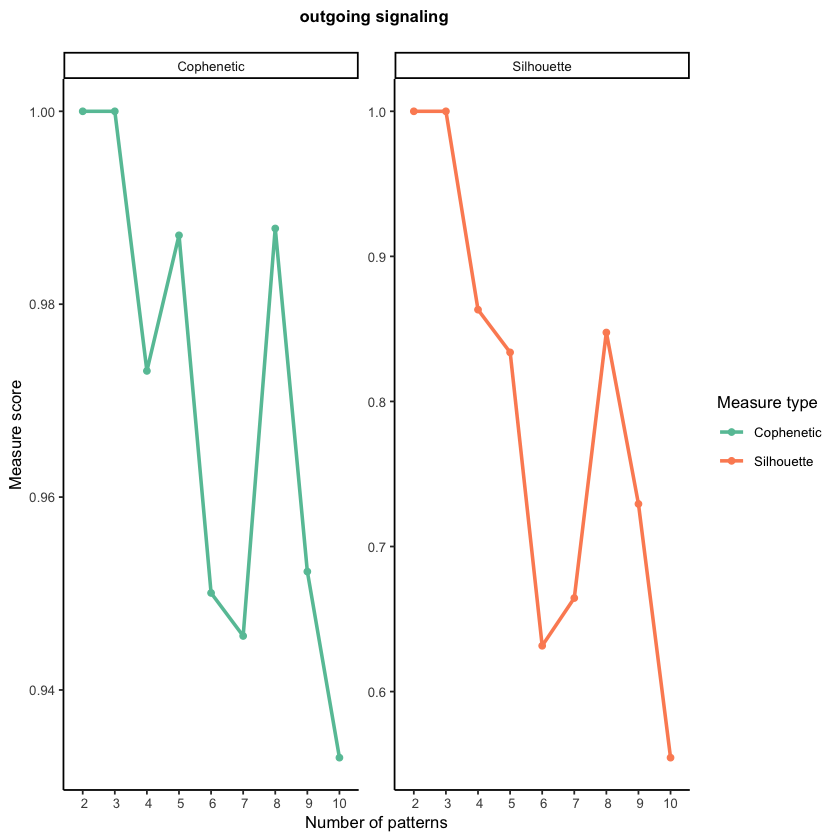

In [64]:
selectK(cellchat, pattern = "outgoing")
ggsave('./figures/cellchat/sk_outgoing.pdf',width = 5,height = 5)

In [66]:
nPatterns = 3
pdf('./figures/cellchat/outgoing-identifyCommunicationPatterns.pdf')
cellchat <- identifyCommunicationPatterns(cellchat, pattern = "outgoing", k = nPatterns)
dev.off()

pdf 
  2

In [67]:
pdf('./figures/cellchat/outgoing_river_plot.pdf')
netAnalysis_river(cellchat, pattern = "outgoing")
dev.off()

Please make sure you have load `library(ggalluvial)` when running this function



pdf 
  2

In [33]:
pdf('./figures/cellchat/outgoing_dot_plot.pdf')
netAnalysis_dot(cellchat, pattern = "outgoing")
dev.off()

pdf 
  2

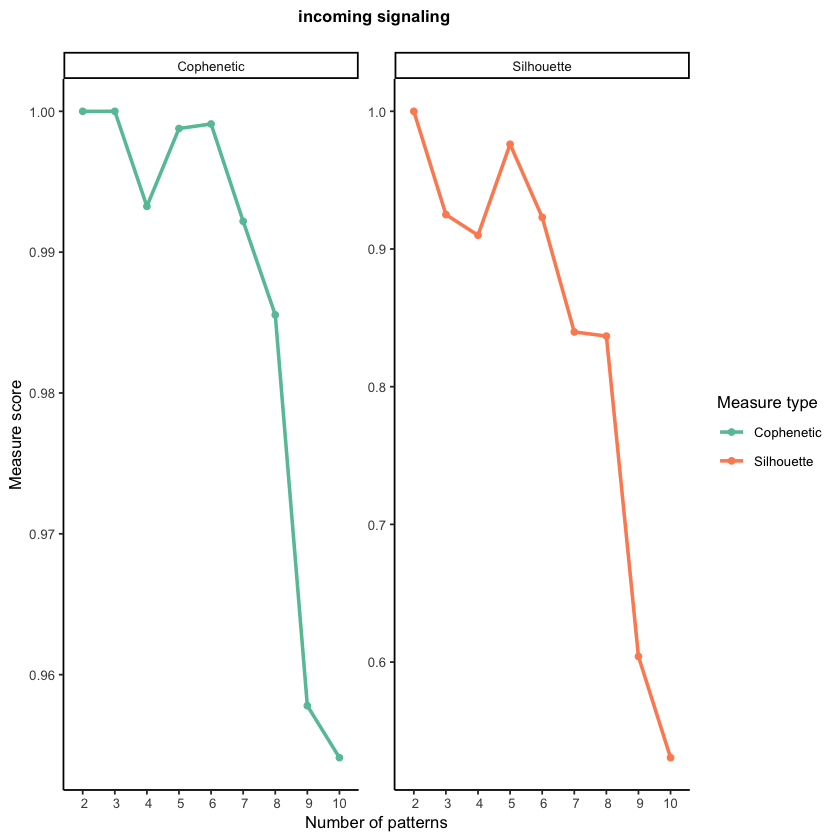

In [65]:
selectK(cellchat, pattern = "incoming")
ggsave('./figures/cellchat/sk_incoming.pdf',width = 5,height = 5)

In [68]:
nPatterns = 3
pdf('./figures/cellchat/imcoming-identifyCommunicationPatterns.pdf')
cellchat <- identifyCommunicationPatterns(cellchat, pattern = "incoming", k = nPatterns)
dev.off()


pdf 
  2

In [69]:
pdf('./figures/cellchat/incoming_river_plot.pdf')
netAnalysis_river(cellchat, pattern = "incoming")
dev.off()

Please make sure you have load `library(ggalluvial)` when running this function



pdf 
  2

In [70]:
pdf('./figures/cellchat/incoming_dot_plot.pdf')
netAnalysis_dot(cellchat, pattern = "incoming")
dev.off()

pdf 
  2

In [71]:
cellchat <- computeNetSimilarity(cellchat, type = "functional")
cellchat <- netEmbedding(cellchat, type = "functional")
#> Manifold learning of the signaling networks for a single dataset
cellchat <- netClustering(cellchat, type = "functional")
#> Classification learning of the signaling networks for a single dataset
# Visualization in 2D-space
pdf('./figures/cellchat/functional.pdf')
netVisual_embedding(cellchat, type = "functional", label.size = 3.5)
dev.off()

Manifold learning of the signaling networks for a single dataset 
Classification learning of the signaling networks for a single dataset 


pdf 
  2

In [72]:
cellchat <- computeNetSimilarity(cellchat, type = "structural")
cellchat <- netEmbedding(cellchat, type = "structural")
#> Manifold learning of the signaling networks for a single dataset
cellchat <- netClustering(cellchat, type = "structural")
#> Classification learning of the signaling networks for a single dataset
# Visualization in 2D-space
pdf('./figures/cellchat/structural.pdf')
netVisual_embedding(cellchat, type = "structural", label.size = 3.5)
dev.off()

Manifold learning of the signaling networks for a single dataset 
Classification learning of the signaling networks for a single dataset 


pdf 
  2

In [73]:
pdf('./figures/cellchat/structural_embeddingZoomIn.pdf')
netVisual_embeddingZoomIn(cellchat, type = "structural", nCol = 2)
dev.off()

pdf 
  2

In [40]:
saveRDS(cellchat, file = "../data/v3.rds")

In [125]:
?netVisual_aggregate

In [130]:
netVisual_aggregate(cellchat, signaling = pathways.show[1],
                   layout='hierarchy',)


ERROR: Error in `[<-`(`*tmp*`, (m1 + 1):nrow(net3), 1, value = space.h/2): subscript out of bounds
